In [43]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [68]:
df = pd.read_csv('readthrough_genes_novel_transcripts_10.tsv', sep='\t')


t_df = df.loc[df.fix_needed.isin(['yes', 'no'])]
pred_df = df.loc[~df.fix_needed.isin(['yes', 'no'])]
print(len(t_df.index))
print(len(pred_df.index))

57
161


In [69]:
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt',
         'gene_id_known_End_dist_abs',
         'gene_id_known_Start_dist_abs',
         'gene_id_known_rt_End_dist_abs',
         'gene_id_known_rt_Start_dist_abs']
label = 'fix_needed'
X = np.array(t_df[feats].values)
y = np.array(t_df[label])
print(X.shape)
print(y.shape)
t_df[['Name', 'fix_needed']].groupby('fix_needed').count()

(57, 8)
(57,)


,Name
fix_needed,
no,16
yes,41


In [70]:
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
y_pred = cross_val_predict(model, X, y)
print(classification_report(t_df[label].tolist(), y_pred, target_names=['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.40      0.50      0.44        16
          no       0.78      0.71      0.74        41

    accuracy                           0.65        57
   macro avg       0.59      0.60      0.59        57
weighted avg       0.68      0.65      0.66        57



In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=True,
                                                    random_state=42)
model = DecisionTreeClassifier()
print('performance on training dataset')
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
report = classification_report(y_train, y_pred)
print("Classification Report:\n", report)
print()
print('performance on test dataset')
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)
print()
print('performance on whole labelled dataset')
y_pred = model.predict(X)
report = classification_report(y, y_pred)
print("Classification Report:\n", report)

wrong_inds = [i for i in range(len(y)) if y[i] != y_pred[i]]
wrong_df = t_df.iloc[wrong_inds]
wrong_df.to_csv('wrong_preds_10.tsv', sep='\t')

performance on training dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      1.00      1.00         8
         yes       1.00      1.00      1.00        20

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


performance on test dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      0.38      0.55         8
         yes       0.81      1.00      0.89        21

    accuracy                           0.83        29
   macro avg       0.90      0.69      0.72        29
weighted avg       0.86      0.83      0.80        29


performance on whole labelled dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      0.69      0.81        16
         yes       0.89      1.00      0.94        41

    accura

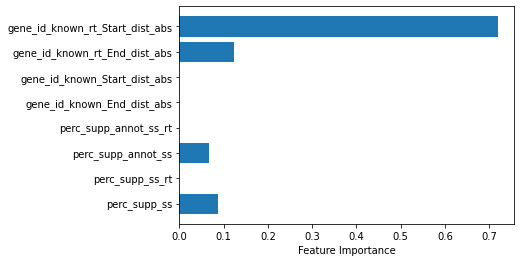

In [72]:
feature_importances = model.feature_importances_

# Visualize feature importances
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feats)
plt.xlabel('Feature Importance')
plt.show()

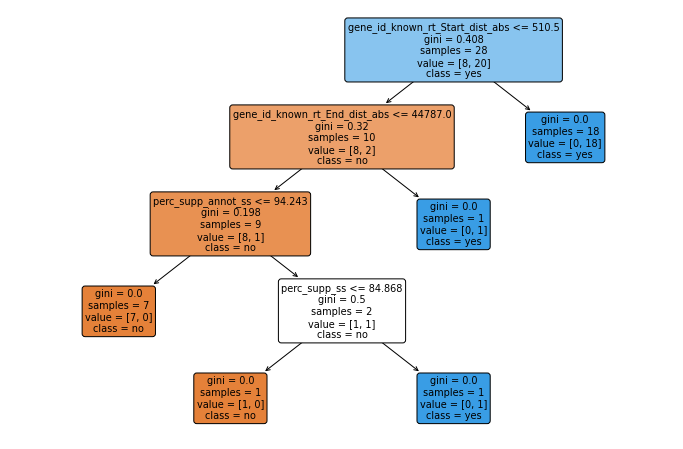

In [73]:
plt.figure(figsize=(12, 8))
# plot_tree(model, filled=True, feature_names=feats, class_names=t_df[label].unique().tolist(), rounded=True)
plot_tree(model, filled=True, feature_names=feats, class_names=['no', 'yes'], rounded=True)

plt.show()

In [74]:
# now implement this classifier in pandas format w/ thresholds
df = pd.read_csv('readthrough_genes_novel_transcripts_10.tsv', sep='\t')
df['fix'] = False

# start of closest rt transcript must be > 510 bp away
inds = df.loc[df.gene_id_known_rt_Start_dist_abs > 510].index
df.loc[inds, 'fix'] = True

# end of the closest rt transcript must be > 45 kbp away
inds = df.loc[df.gene_id_known_rt_End_dist_abs > 45000].index
df.loc[inds, 'fix'] = True

# % of sss annotated in best matching non-rt transcripts
# must be >94
# % of sss annotated in actual transcript mush be > 84%
inds = df.loc[(df.perc_supp_annot_ss > 94)&(df.perc_supp_annot_ss > 84)].index
df.loc[inds, 'fix'] = True

df[['fix_needed', 'fix', 'Name']].groupby(['fix_needed', 'fix']).count().reset_index()

,fix_needed,fix,Name
0,could go either way,True,1
1,lost cause,False,5
2,lost cause,True,12
3,no,False,10
4,no,True,6
5,yes,True,41
